# Star formation rate in the multiverse

The following code is a modified version of the one written by Bousso and Leichenauer for the star formation rate in a multiverse setting.
There are six parameters that can be varied:
\begin{align}
& h, \text{  the reduced Hubble constant} \\
& \Omega_{\text{m}} \text{  the total matter content today} \\
& \Omega_{\text{b}} \text{  the baryonic matter content today} \\
& \Omega_{\Lambda} \text{  the energy density due to the cosmological constant today} \\
&  \sigma_8 \text{  the variance at } 8/h \text{ Mpc today} \\
& n_{\text{s}} \text{  the scalar spectral index}
\end{align}

In [1]:
#Takes a while to precompile
using Plots
using DifferentialEquations
using SpecialFunctions
using QuadGK
using Cuba
using ForwardDiff
using NLsolve

### Temperature at equality
The temperature at equality $T_{\text{eq}}$ can be written as a function of the matter to photon ratio. In the thesis, the procedure is described in a bit more detail, but to recap the important steps:
The radiation energy density is given by
\begin{equation}
\rho_r = \frac{\pi^2}{15(\hbar c)^3}\left[1 + \frac{21}{8}\left(\frac{4}{11}\right)^{4/3} \right](kT)^4
\end{equation}
while the matter energy density reads
\begin{equation}
\rho_m(T) = \xi\text{}n_{\gamma} = \xi \frac{2\zeta(3)}{\pi^2(\hbar c)^3}(kT)^3 
\end{equation}
where $n_{\gamma}$ is the number density of photons. From these, one then get the equality temperature as a function of $\xi$ only:
\begin{equation}
T_{\text{eq}} = \frac{30\zeta(3)}{\pi^4 k}\left[1 + \frac{21}{8}\left(\frac{4}{11}\right)^{4/3}\right]^{-1}\xi
\end{equation}

In [2]:
function nγ(T)
    """
    Number density of photons per cubic meter as a function of temperature
    """
    kb = 1.38e-23 #J/K
    ħ = 1.05e-34 #J*s
    c = 2.99e8 #m/s
    return 2 * zeta(3) / π^2 * (kb/(ħ*c))^3 * T^3
end;
 

function Tequality(ξ)
    """
    Temperature of equality as a function of the matter to photon ratio 
    """
    factor1 = 30 * zeta(3) / pi^4
    factor2 = 1 / (1 + 21/8 * (4/11)^(4/3))
    return factor1 * factor2 * ξ
end;

## Radiation energy density

As explained in the thesis, if one reduces $H_0$ (e.g. make it 100 times smaller), the radiation density $\Omega_{\text{rad}}$ will become a lot larger (of order unity in that case). One should therefore be careful that 
\begin{equation}
\Omega_{\text{rad}} + \Omega_{\text{m}} + \Omega_{\Lambda} = 1.
\end{equation}

In [3]:
function Ωrad(h)
    """
    The fractional radiation density today as a function of the reduced Hubble
    constant h. For the fiducial cosmology it is negligible.
    """
    kb = 1.38e-23 #J/K
    ħ = 1.05e-34 # J*s
    c = 2.99e8 # m/s
    G = 6.67e-11 # m^3/kg/s^2
    
    T0 = 2.725 #K
    H0 = 100 * h * 3.15e16 / 3.09e19; # 1/gigayear
    H0_second = H0 / (3.15e16) # 1/s
    factor = 1 + (21/8) * (4/11)^(4/3) #takes into account the neutrinos
    
    factor * 8 * pi * G / ( 3 * H0_second^2) * (pi^2 / (15 * c^2 * (ħ * c)^3)) * (kb * T0)^4
end;

function Ωγ(h)
    """
    The fractional photon energy density
    """
    kb = 1.38e-23 #J/K
    ħ = 1.05e-34 # J*s
    c = 2.99e8 # m/s
    G = 6.67e-11 # m^3/kg/s^2
    
    T0 = 2.725 #K
    H0 = 100 * h * 3.15e16 / 3.09e19; # 1/gigayear
    H0_second = H0 / (3.15e16) # 1/s
    
    8 * pi * G / ( 3 * H0_second^2) * (pi^2 / (15 * c^2 * (ħ * c)^3)) * (kb * T0)^4
end;

In [4]:
function ρvir(afunc, t, Λ, ρeq, aeq)
    """
    A fit of the virialisation density taken from
    Tegmark & al. paper, "Dimensionless constants, cosmology,
    and other Dark matters", Appendix A
    """
    x = Λ * afunc(t)^3 / (8 * pi * ρeq * aeq^3)
    return Λ / (x * 8 * pi) * (18*pi^2 + 52.8 * x^.7 + 16*x)
end;

function tgrav(afl, tvir, Λ, ρeq, aeq)
    """
    The time it takes a halo to collapse gravitationnally
    """
    return 1 / sqrt(ρvir(afl, tvir, Λ, ρeq, aeq) )
end;

In [5]:
function function_for_t_min(F, x, t, afunc, Λ, ρeq, aeq)
    f = .35
    A= sqrt(32 / (3*pi))
    F[1] = t - x[1] - f / A * tgrav(afunc, x[1], Λ, ρeq, aeq)
end;
function t_min(t, afunc, Λ, ρeq, aeq)
    """
    The minimal time needed for the halo to form
    """
    partial(F,x) = function_for_t_min(F, x, t, afunc, Λ, ρeq, aeq)
    nlsolve(partial, [3.]).zero[1]
end;

In [6]:
function Mₘᵢₙ(afunc, t, Λ, ρeq, aeq)
    """
    The mass threshhold at a given time, for which
    a star may form. Follows from thermodynamical considerations.
    """
    if t < 0
        return 0
    end
    kb = 1.307e-23 * (3.15e16)^2
    T = 1e4
    μ = .6 * 1.672e-27 
    g = 6.673e-11 * (3.15e16)^2
    Msun = 2e30
    term1 = 1.5 * log10((3*(kb*T)/(.6*μ) * (3/(4*pi))^(1/3) * (Msun * g)^(-2. /3) ))
    term2 = .5*log10(ρvir(afunc, t, Λ, ρeq, aeq))
    return term1 - term2
end;

In [7]:
function Mₘₐₓ(afunc,t, Λ, ρeq, aeq, fb)
    """
    The upper limit for the mass of a halo that may still collapse at a given time.
    """
    if t<0
        return 0
    end
    mp = 1.672e-27
    Λ₀ = 1e-23 / 1e6 * (3.15e16)^3 / 1e7 #IS NOT THE COSMOLOGICAL CONSTANT!
    g = 6.673e-11 * (3.15e16)^2
    X = .76
    Msun = 2e30
    term1 = sqrt(6/pi)
    term2 = ((fb * X^2 * Λ₀)/(.6*mp^2))^(3/2)
    term3 = 1/g^(5/2) / Msun * ρvir(afunc, t, Λ, ρeq, aeq)^(1/4)
    return log10(term1 * term2 * term3 )
end;

In [8]:
function nscorr(logM, ξₘ, T0, ns, Ωm, h)
    """
    A generalization of the fit of Tegmark et al. to take
    into account the possibility that the scalar spectral
    index ns deviates from .98 (nscorr = 1 for ns = .98).
    ξₘ must be given in kilos/m³
    """
    Msun = 2e30;
    Mpc_to_m = 3.09e22;
    aRfact = (3/(4*pi*ξₘ*nγ(T0)))^(1/3) * Msun^(1/3) / Mpc_to_m * h; 
    factor1 = ns - 0.98
    factor2 = 0.6 + 3*log10(Ωm*h) + 3*log10(aRfact) + logM
    factor3 = (Ωm*h)^(ns-0.98)
    return sqrt((1 - 0.48*factor1*factor2)*factor3)
end;

In [9]:
function Σ(logM, Meq, ξₘ, T0, ns, Ωm, h)
    """
    Fit of the variance. Taken from Tegmark et al. as well, appendix A. 
    """
    μ = 10^logM/Meq
    α = -0.27
    fit = ( (9.1*μ^(-2/3))^α + (50.5*log10(834 + μ^(-1/3)) - 92)^α )^(1/α)
    return nscorr(logM, ξₘ, T0, ns, Ωm, h) * fit
end;

In [10]:
function f_for_q(F, x, logM8, Meq, ttoday, growthfunc, σ₈, ξₘ, T0, ns, Ωm, h)
    q = x[1]
    F[1] = σ₈ - sqrt(s²(logM8, Meq, ξₘ, T0, ns, Ωm, h, q)*growthfunc(ttoday)[2]^2)
end;

function q(logM8, Meq, ttoday, growthfunc, σ₈, ξₘ, T0, ns, Ωm, h)
    """
    q is a correction to the variance, so that σ²(M8,today) be equal 
    to σ₈.
    """
    partial(F,x) = f_for_q(F, x, logM8, Meq, ttoday,growthfunc, σ₈, ξₘ, T0, ns, Ωm, h)
    nlsolve(partial, [0.1]).zero[1]
end;

In [11]:
function s²(logM, Meq, ξₘ, T0, ns, Ωm, h, q)
    """
    Q₀ is the amplitude of primordial fluctuations. 
    For q, See function q above directly.
    """
    Q₀ = 2e-5
    return (q*Q₀*Σ(logM, Meq, ξₘ, T0, ns, Ωm, h))^2
end;

In [12]:
function ds_dM(logM, Meq, q)
    """
    The derivative of the variance, computed analitically. 
    It is needed for the star formation rate.
    """
    Q0 = 2e-5
    μ = 10^logM  / Meq
    factor = 50.5 / log(10)
    α = -0.27
    term1 = -factor * (-92 + factor*log(834 + 1/μ^(1/3)))^(-1 + α) / (834 + 1/μ^(1/3))
    term2 = -2*9.1^α * μ^(1/3 - 2α/3)
    term3 = ( (-92 + factor*log(834 + 1/μ^(1/3)))^α + 9.1^α * μ^(-2α/3) )^(-1 + 1/α) 
    term4 = 3*μ^(4/3)
    dμdm = log(10) * μ
    return q * Q0 * (term1 + term2) * term3 /term4 * dμdm
end;

In [13]:
function dnscorr_dm(logM, Meq, ξₘ, T0, ns, Ωm, h, q)
    dnscorr_dm = .5/nscorr(logM, ξₘ, T0, ns, Ωm, h) * (-0.48*(ns-0.98)*(Ωm*h)^(ns-.98))
    term1 = dnscorr_dm*sqrt(s²(logM, Meq, ξₘ, T0, ns, Ωm, h, q))
    term2 = nscorr(logM, ξₘ, T0, ns, Ωm, h) * ds_dM(logM, Meq, q)
    term1 + term2
end;

In [14]:
function f_for_a(a,p,t)
    ρeq, aeq, Λ = p
    matter = 8*pi*ρeq * aeq^4 / 3 / a^2
    radiation = 8 * pi * ρeq * aeq^3/ 3 / a
    cosmoconstant = Λ/3 * a^2
    k = -1
    sqrt(matter + radiation + cosmoconstant - k)
end;
function acurved(ρeq, aeq, Λ)
    p = [ρeq, aeq,Λ]
    u0 = aeq
    tspan = (0,50*sqrt(3/Λ))
    prob = ODEProblem(f_for_a, u0, tspan, p)
    solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);
end;

In [15]:
function f_for_aflat(a,p,t)
    ρeq, aeq, Λ = p
    matter = 8*pi*ρeq * aeq^4 / 3 / a^2
    radiation = 8 * pi * ρeq * aeq^3/ 3 / a
    cosmoconstant = Λ/3 * a^2
    sqrt(matter + radiation + cosmoconstant)
end;

function aflat(ρeq, aeq, Λ)
    p = [ρeq, aeq, Λ]
    u0 = aeq
    tspan = (0.0, 50*sqrt(3/Λ))
    prob = ODEProblem(f_for_aflat, u0, tspan, p)
    return solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
end;

In [16]:
function Hubble(t, a)
    """
    The hubble rate
    """
    return ForwardDiff.derivative(a,t) /a(t)
end;

## Today
We decided to define "today" in the multiverse as the time corresponding to the CMB having a temperature of $T=2.7255$K.
This means that all the parameters, and in particular the reduced Hubble constant $h$ are defined at that time $t_0$.

In [17]:
function f_for_today(F, x, H0, a)
    t = x[1]
    F[1] = H0 - Hubble(t,a)
end;
function today(H0, a_func)
    """
    Returns the time for which the hubble rate is equal to H0.
    This time in turn defines "today", which is given in gigayears.
    """
    partial(F,x) = f_for_today(F, x, H0, a_func)
    nlsolve(partial, [10.]).zero[1]
end;

In [18]:
function f_for_Growth(du, u, p, t)
    ρeq, aeq, a = p
    return -2 * Hubble(t,a) * du + 4 * pi * ρeq * (aeq / a(t))^3 * u #-2 * Hubble(t) * du
end;
function Growth(ρeq, aeq, a, Λ)
    """
    The growth function for a matter dominated unvierse.
    """
    p = [ρeq, aeq, a]
    du₀ = 1.5 * Hubble(0, a)
    u₀ = 2.5
    tspan = (0.0,50*sqrt(3/Λ))
    prob3 = SecondOrderODEProblem(f_for_Growth, du₀, u₀, tspan, p)
    solve(prob3, alg = Vern7(),reltol=1e-8, abstol=1e-10)
end;

In [19]:
function δcrit(t,growthfunc)
    """
    δc is the linearly exptrapolated critical density for collapse.
    """
    δc = (3/20) * (12*pi)^(2/3)
    return δc / growthfunc(t)[2]
end;
function dδcrit_dt(t,growthfunc)
    return -δcrit(t,growthfunc)/growthfunc(t)[2] * growthfunc(t)[1]
end;

In [20]:
function M8(ξₘ,h)
    """
    Computes the mass enclosed in a sphere of radius 8/h Mpc.    
    ξₘ is the matter mass to photon ratio and must be given in kilos
    """
    Msun = 2e30 #kg
    Mpc_to_m = 3.09e22 #conversion factor 
    T0 = 2.725 #Kelvin
    ρₘ = ξₘ * nγ(T0) * Mpc_to_m^3 / Msun #Msun / Mpc³
    V = (4/3) * pi * (8/h)^3 #Mpc³
    return ρₘ * V
end;

In [21]:
function d²β_dM1dtvir(M1, t1, M2, t2, Meq, growthfunc, ξₘ, T0, ns, Ωm, h, q)
    """ 
    β is a function that is used for convenience in BL's paper (eq. 2.19). 
    Its second derivative appears in the SFR. 
    """

    s²M1 = s²(M1, Meq, ξₘ, T0, ns, Ωm, h, q) 
    s²M2 = s²(M2, Meq, ξₘ, T0, ns, Ωm, h, q)
    dscorr = dnscorr_dm(M1, Meq, ξₘ, T0, ns, Ωm, h, q)
    
    Δs² = abs(s²M1- s²M2) #The absolute value is used, since for very small values,  
                         #it may happen that the difference is negative 
    Δδc² = (δcrit(t1,growthfunc) - δcrit(t2,growthfunc))^2
    factor = sqrt(2*s²M1/pi)
    num = (Δs² - Δδc²) * dscorr * dδcrit_dt(t1, growthfunc)
    denom = Δs²^(5/2)
    arg = - .5 * Δδc² / Δs²
    return factor * num / denom * exp(arg)
end;

In [22]:
function dFdM(t, logM, Meq, growthfunc, ξₘ, T0, ns, Ωm, h, q)
    """
    F is the function of Lacey & Cole "Merger rate in hierarchical 
    models of galaxy formation", which is an extension of the PS
    hierarchical model.
    """ 
    dscorr = dnscorr_dm(logM, Meq, ξₘ, T0, ns, Ωm, h, q)
    ssquared = s²(logM, Meq, ξₘ, T0, ns, Ωm, h, q) 
    
    num = sqrt(ssquared) * δcrit(t, growthfunc) * dscorr 
    denom = ssquared^(3/2)
    arg = - .5 * δcrit(t, growthfunc)^2 / ssquared
    return - sqrt(2/pi) * num/denom * exp(arg)
end;

In [23]:
function cosmology(h, Ωm, Ωb, ΩΛ)
    """
    This function takes care of computing all relevant cosmological
    parameters for a given set of values.
    """
    ΔN = 0;
    Ωk = 10e-10; #dimensionless
    T0 = 2.7255; #Kelvin
    Q0 = 2e-5; #dimensionless, the amplitude of primordial fluctuations

    H0 = 100 * h * 3.15e16 / 3.09e19; # 1/gigayear
    H0_second = H0 / (3.15e16) # 1/s
    fb = Ωb/Ωm; #dimensionless
    Λ  = 3 * H0^2 * ΩΛ; #1 / (Gigayear)^2

    ħ = 1.05e-34 # J*s
    c = 2.99e8; # m/s
    G = 6.67e-11; # m³kg⁻¹s⁻²
    Joules_to_eV = 6.24e18; 
    Msun = 2e30; # kg

    ξ = Joules_to_eV*(3*H0_second^2*Ωm)/(8*π*G)/nγ(T0)*c^2; #Matter to photons ratio in eV
    ξkilo = (3*H0_second^2*Ωm)/(8*π*G)/nγ(T0); #same as ξ but in units of kilo

    Teq = Tequality(ξ);# eV
    ρeq = (1 + 21/8 * (4/11)^(4/3)) * pi^2 / 15  * (Teq/(1.22e28))^4 * (5.39121e-44)^(-2) * (3.15e16)^2;
    aeq = ((3*Ωm)/(8 * pi * ρeq * H0))^(1/3) * exp(ΔN)/sqrt(Ωk); #Unitless
    Meq = ((ħ*c)/G)^(3/2)*(ξkilo)^(-2) / (Msun); #Solar masses
    
    
    
    return  fb, Λ, Teq, ρeq, aeq, Meq, ξkilo, H0
end;

In [24]:
function integrand_SFR(k, f, t, growthfunc, cosmo_params, afl, Mlim, tlim, M1min, M1max)
    """
    The integrand of the SFR, taken from BL.
    """
    T0 = 2.725; #K
    fb, Λ, Teq, ρeq, aeq, Meq, ξkilo, q, h, Ωm0, ns = cosmo_params
    
    
    
    Mmin = Mlim[1]
    Mmax = Mlim[2]
    
    tmin = tlim[1]
    tmax = tlim[2]
    
    
    A = sqrt(32/(3*pi))
    
    ΔM = Mmax - Mmin
    Δtvir = tmax - tmin
    ΔM1 = M1max - M1min
    
    LogM = Mmin + ΔM * k[1]
    tvir = tmin + Δtvir * k[2]
    M1   = M1min + ΔM1 * k[3]

    
    factor1 = -10^(-M1)*d²β_dM1dtvir(M1 + LogM, tvir, LogM, t, Meq, growthfunc, ξkilo, T0, ns, Ωm0, h, q) 
    factor2 = 1 / tgrav(afl, tvir, Λ, ρeq, aeq)
    factor3 = dFdM(t, LogM, Meq, growthfunc, ξkilo, T0, ns, Ωm0, h, q)
    
    f[1] = A * fb * ΔM * Δtvir * ΔM1 * factor1 * factor2 * factor3
end;

In [25]:
function SFR(t, cosmo_params, growthfunc, afunc, Mlim, tlim, M1min=-log10(2), M1max = 0)
    partial(k,f) = integrand_SFR(k, f, t, growthfunc, cosmo_params, afunc, Mlim, tlim, M1min, M1max)
    cuhre(partial,3)
end;

In [26]:
function final_SFR(h, Ωm, Ωb, ΩΛ, σ₈, ns)
    Ωk0 = 1e-10; #dimensionless
    H0 = 100 * h * 3.15e16 / 3.09e19; # 1/gigayear
    T0  = 2.725; #Kelvin, temperature of the CMB today

    fb, Λ, Teq, ρeq, aeq, Meq, ξkilo, H0 = cosmology(h, Ωm, Ωb, ΩΛ) 

    afl = aflat(ρeq, aeq, Λ);
    growth = Growth(ρeq, aeq, afl, Λ) ;
    
    logM8 = log10(M8(ξkilo, h))
    ttoday = today(H0, afl)
    qq = q(logM8, Meq, ttoday, growth, σ₈,  ξkilo, T0, ns, Ωm, h)

    cosmo_params = [fb, Λ, Teq, ρeq, aeq, Meq, ξkilo, qq, h, Ωm, ns]
    
    N = 40
    times = LinRange(0.1,10,N)
    y = zeros(N)
    for t in enumerate(times)
        time = t[2]
        Mmin = Mₘᵢₙ(afl, time, Λ, ρeq, aeq)
        Mmax = Mₘₐₓ(afl, time, Λ, ρeq, aeq, fb)
        tmin = t_min(time, afl, Λ, ρeq, aeq)
        tmax = .999*time
        
        Mlim = [Mmin, Mmax]
        tlim = [tmin, tmax]
    
        y[t[1]] = SFR(time, cosmo_params, growth, afl, Mlim, tlim)[1][1]
    end
    return times, y
end;

## Examples

Below are two examples of the code in action, the first one is for the fiducial cosmology, while the second is for a greater value of $\Omega_{\text{m}} = .615$, caeteris paribus. It takes about two and a half minutes to compute on my system.

In [ ]:
h = .674
Ωm = .315
Ωb = .049
ΩΛ = 1 - Ωm - Ωrad(h)
σ₈ = .811
ns = .96
N = 40
t_y = zeros(2,N)

t_y = final_SFR(h, Ωm, Ωb, ΩΛ, σ₈, ns);

gr() #Change this to plotlyjs() for a more interactive plot (takes a while to load)
scatter(t_y, 
    legend =:none,
    grid =:none,
    xlabel =:"\$ Time [Gigayears] \$",
    ylabel =:"\$ SFR [M_{\\bigodot} yr^{-1}Mpc^{-1}] \$")

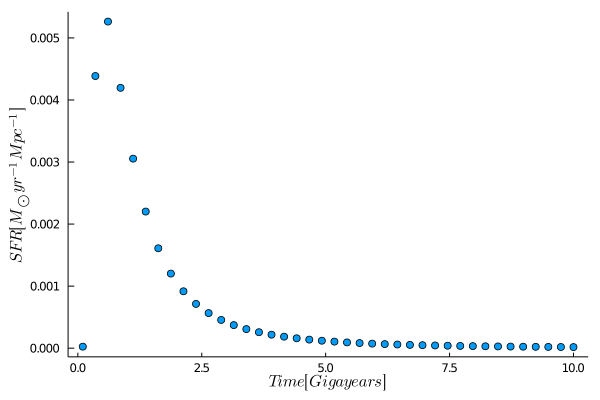

In [35]:
h = .674
Ωm = .815
Ωb = .049
ΩΛ = 1 - Ωm - Ωrad(h)
σ₈ = .811
ns = .96
N = 40
t_y = zeros(2,N)

t_y = final_SFR(h, Ωm, Ωb, ΩΛ, σ₈, ns);

gr() #Change this to plotlyjs() for a more interactive plot (takes a while to load)
scatter(t_y, 
    legend =:none,
    grid =:none,
    xlabel =:"\$ Time [Gigayears] \$",
    ylabel =:"\$ SFR [M_{\\bigodot} yr^{-1}Mpc^{-1}] \$")